In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
#1. Data Loading and Exploration

In [4]:
# Load the data
df = pd.read_csv('rating_short.csv')
df

,userid,productid,rating,date
0,A1Z3YJF1S8Z1M3,B000M9ISQ2,5.0,1199750400
1,ALDXDYEGKB27G,B002L6HE9G,4.0,1331337600
2,A15LOGO6NBSI6B,B007MXGG5Q,5.0,1358640000
3,A23LX12CA3G4FG,B008HOEDYU,1.0,1385337600
4,A3TV7QFYXAG130,B0069R7TAM,5.0,1402963200
...,...,...,...,...
78240,A1TWH3KD5YJQHM,B0035ERKYW,5.0,1347321600
78241,AMXTPQY23TN07,B004RB8CT4,4.0,1367539200
78242,A1FCG75OIMKQCT,B002LTWDSK,2.0,1375315200
78243,A2X2NI89D5BQ2E,B004P1V8TM,5.0,1392768000


In [5]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (78245, 4)

Column Names: ['userid', 'productid', 'rating', 'date']

First 5 rows:


,userid,productid,rating,date
0,A1Z3YJF1S8Z1M3,B000M9ISQ2,5.0,1199750400
1,ALDXDYEGKB27G,B002L6HE9G,4.0,1331337600
2,A15LOGO6NBSI6B,B007MXGG5Q,5.0,1358640000
3,A23LX12CA3G4FG,B008HOEDYU,1.0,1385337600
4,A3TV7QFYXAG130,B0069R7TAM,5.0,1402963200


In [6]:
# Rename columns for consistency
if 'userid' in df.columns:
    df = df.rename(columns={'userid': 'user_id', 'productid': 'item_id'})

# Remove timestamp column if exists
if 'date' in df.columns:
    df = df.drop('date', axis=1)

print("Cleaned dataset:")
df.head()

Cleaned dataset:


,user_id,item_id,rating
0,A1Z3YJF1S8Z1M3,B000M9ISQ2,5.0
1,ALDXDYEGKB27G,B002L6HE9G,4.0
2,A15LOGO6NBSI6B,B007MXGG5Q,5.0
3,A23LX12CA3G4FG,B008HOEDYU,1.0
4,A3TV7QFYXAG130,B0069R7TAM,5.0


In [7]:
# Basic statistics
print("Dataset Statistics:")
print(f"Total ratings: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique items: {df['item_id'].nunique():,}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
print(f"Average rating: {df['rating'].mean():.2f}")
print(f"Data sparsity: {1 - len(df) / (df['user_id'].nunique() * df['item_id'].nunique()):.2%}")

Dataset Statistics:
Total ratings: 78,245
Unique users: 76,430
Unique items: 40,228
Rating range: 1.0 - 5.0
Average rating: 4.01
Data sparsity: 100.00%


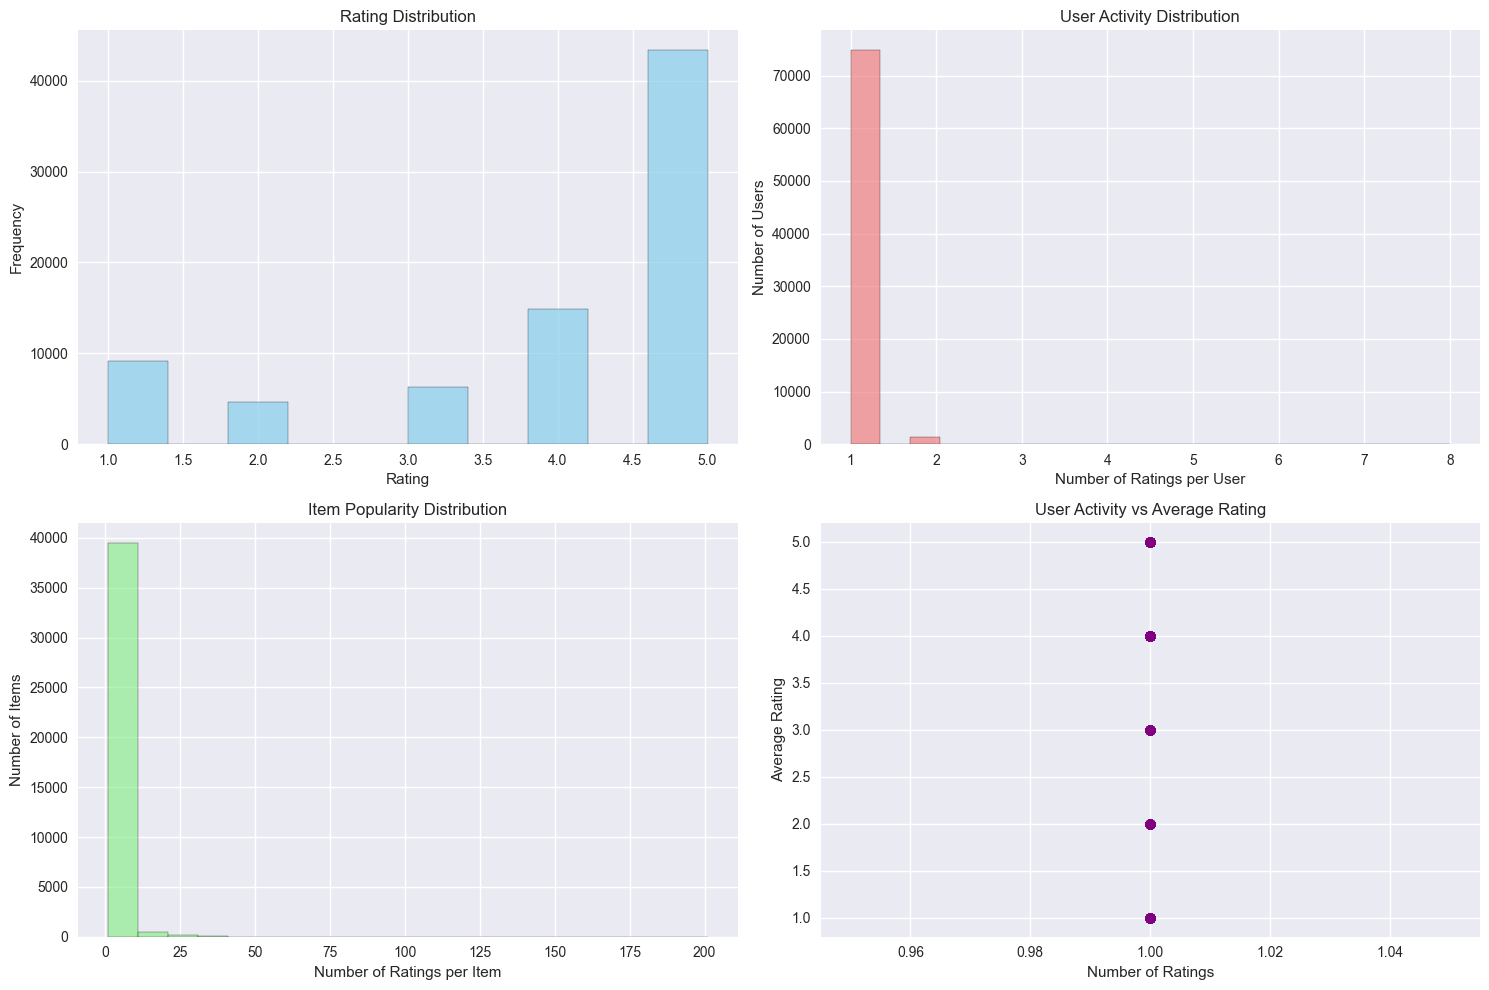

In [8]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(df['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# User activity distribution
user_activity = df.groupby('user_id').size()
axes[0, 1].hist(user_activity, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].set_xlabel('Number of Ratings per User')
axes[0, 1].set_ylabel('Number of Users')

# Item popularity distribution
item_popularity = df.groupby('item_id').size()
axes[1, 0].hist(item_popularity, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Item Popularity Distribution')
axes[1, 0].set_xlabel('Number of Ratings per Item')
axes[1, 0].set_ylabel('Number of Items')

# Rating distribution by user activity
df_sample = df.sample(min(1000, len(df)))  # Sample for performance
axes[1, 1].scatter(df_sample.groupby('user_id')['rating'].count(), 
                   df_sample.groupby('user_id')['rating'].mean(), 
                   alpha=0.6, color='purple')
axes[1, 1].set_title('User Activity vs Average Rating')
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_ylabel('Average Rating')

plt.tight_layout()
plt.show()

In [9]:
#2. Data Preprocessing

In [10]:
# Create user and item mappings
unique_users = df['user_id'].unique()
unique_items = df['item_id'].unique()

user_mapping = {user: idx for idx, user in enumerate(unique_users)}
item_mapping = {item: idx for idx, item in enumerate(unique_items)}

reverse_user_mapping = {v: k for k, v in user_mapping.items()}
reverse_item_mapping = {v: k for k, v in item_mapping.items()}

# Add mapped indices
df['user_idx'] = df['user_id'].map(user_mapping)
df['item_idx'] = df['item_id'].map(item_mapping)

print(f"Created mappings for {len(user_mapping)} users and {len(item_mapping)} items")

Created mappings for 76430 users and 40228 items


In [11]:
import numpy as np
from scipy.sparse import lil_matrix

# Create user-item matrix using sparse representation
n_users = len(user_mapping)
n_items = len(item_mapping)

# Initialize sparse matrix (LIL is efficient for row-wise assignment)
user_item_matrix = lil_matrix((n_users, n_items))

# Fill the matrix with ratings
for _, row in df.iterrows():
    user_item_matrix[row['user_idx'], row['item_idx']] = row['rating']

# Convert to CSR format for efficient calculations
user_item_matrix = user_item_matrix.tocsr()

# Print matrix info
non_zero = user_item_matrix.count_nonzero()
total = user_item_matrix.shape[0] * user_item_matrix.shape[1]
sparsity = non_zero / total

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Matrix sparsity: {sparsity:.2%}")


User-item matrix shape: (76430, 40228)
Matrix sparsity: 0.00%


In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 62596
Test set size: 15649


In [13]:
#3. Collaborative Filtering Models
#3.1 User-Based Collaborative Filtering

In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def user_based_cf(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10, n_neighbors=50):
    """Memory-efficient User-based Collaborative Filtering"""
    if user_id not in user_mapping:
        return []
    
    user_idx = user_mapping[user_id]
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}
    
    # Compute similarity of the given user with all others (row-wise only)
    user_vector = user_item_matrix[user_idx]
    user_sim_scores = cosine_similarity(user_vector, user_item_matrix).flatten()
    
    # Get top similar users (excluding the user itself)
    similar_users = np.argsort(user_sim_scores)[::-1][1:n_neighbors+1]
    
    # Get user ratings and initialize recommendation scores
    user_ratings = user_item_matrix[user_idx].toarray().flatten() if hasattr(user_item_matrix, "toarray") else user_item_matrix[user_idx]
    recommendations = np.zeros_like(user_ratings, dtype=float)
    
    # Aggregate ratings from similar users
    for similar_user in similar_users:
        similarity = user_sim_scores[similar_user]
        similar_user_ratings = user_item_matrix[similar_user].toarray().flatten() if hasattr(user_item_matrix, "toarray") else user_item_matrix[similar_user]
        
        mask = (user_ratings == 0) & (similar_user_ratings > 0)
        recommendations += mask * similar_user_ratings * similarity
    
    # Rank unrated items by score
    unrated_items = np.where(user_ratings == 0)[0]
    item_scores = [(reverse_item_mapping[item], recommendations[item]) 
                   for item in unrated_items if recommendations[item] > 0]
    
    return sorted(item_scores, key=lambda x: x[1], reverse=True)[:n_recommendations]


# ✅ Test user-based CF
sample_user = list(user_mapping.keys())[0]
user_cf_recs = user_based_cf(sample_user, user_item_matrix, user_mapping, item_mapping)

print(f"User-based CF recommendations for {sample_user}:")
for i, (item, score) in enumerate(user_cf_recs[:5], 1):
    print(f"{i}. {item} (score: {score:.4f})")


User-based CF recommendations for A1Z3YJF1S8Z1M3:


In [15]:
#3.2 Item-Based Collaborative Filtering

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def item_based_cf_vectorized(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10, n_neighbors=50):
    """Vectorized Item-based Collaborative Filtering (memory & speed optimized)."""
    
    # Check user existence
    if user_id not in user_mapping:
        return []
    
    user_idx = user_mapping[user_id]
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}

    # Get user's ratings
    user_ratings = user_item_matrix[user_idx].toarray().flatten() if hasattr(user_item_matrix, "toarray") else user_item_matrix[user_idx]
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        return []  # user hasn't rated anything yet

    # Get the item vectors the user has rated
    rated_item_vectors = user_item_matrix[:, rated_items].T

    # Compute similarity of all items with those rated by the user
    # This gives a matrix of shape (all_items, rated_items)
    item_sim_matrix = cosine_similarity(user_item_matrix.T, rated_item_vectors)

    # Compute weighted average score for each item
    weighted_scores = item_sim_matrix.dot(user_ratings[rated_items])
    sim_sums = np.sum(np.abs(item_sim_matrix), axis=1)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_scores = np.where(sim_sums != 0, weighted_scores / sim_sums, 0)

    # Remove already-rated items
    predicted_scores[rated_items] = 0

    # Get top-N recommended items
    top_indices = np.argsort(predicted_scores)[::-1][:n_recommendations]
    recommendations = [(reverse_item_mapping[idx], predicted_scores[idx]) for idx in top_indices if predicted_scores[idx] > 0]

    return recommendations


# ✅ Test the vectorized CF
sample_user = list(user_mapping.keys())[0]
item_cf_recs_vec = item_based_cf_vectorized(sample_user, user_item_matrix, user_mapping, item_mapping)

print(f"\nVectorized Item-based CF recommendations for {sample_user}:")
for i, (item, score) in enumerate(item_cf_recs_vec[:5], 1):
    print(f"{i}. {item} (score: {score:.4f})")



Vectorized Item-based CF recommendations for A1Z3YJF1S8Z1M3:


In [17]:
#3.3 Matrix Factorization (SVD)

In [18]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

def matrix_factorization_svd(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10, n_components=50):
    """Matrix factorization using Truncated SVD (optimized and memory-safe)."""
    if user_id not in user_mapping:
        return []
    
    user_idx = user_mapping[user_id]
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}

    # Ensure matrix is in CSR format (TruncatedSVD requires CSR/CSC)
    if not hasattr(user_item_matrix, "tocsr"):
        user_item_matrix = csr_matrix(user_item_matrix)
    else:
        user_item_matrix = user_item_matrix.tocsr()

    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T  # shape: (n_items, n_components)

    # Predict ratings for all items for this user
    predicted_ratings = np.dot(user_factors[user_idx], item_factors.T)

    # Convert user ratings to dense 1D array
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    unrated_items = np.where(user_ratings == 0)[0]

    # Create list of (item_id, predicted_score)
    item_scores = [(reverse_item_mapping[item], predicted_ratings[item]) for item in unrated_items]

    # Sort by score (descending) and get top N
    return sorted(item_scores, key=lambda x: x[1], reverse=True)[:n_recommendations]


# ✅ Test SVD
sample_user = list(user_mapping.keys())[0]
svd_recs = matrix_factorization_svd(sample_user, user_item_matrix, user_mapping, item_mapping)

print(f"\nSVD recommendations for {sample_user}:")
for i, (item, score) in enumerate(svd_recs[:5], 1):
    print(f"{i}. {item} (score: {score:.4f})")



SVD recommendations for A1Z3YJF1S8Z1M3:
1. B000BQ7GW8 (score: 0.0000)
2. B000VX6XL6 (score: 0.0000)
3. B0057OCDQS (score: 0.0000)
4. B005X1Y7I2 (score: 0.0000)
5. B002MAPRYU (score: 0.0000)


In [19]:
#3.4 Non-negative Matrix Factorization (NMF)

In [20]:
from sklearn.decomposition import NMF
import numpy as np
from scipy.sparse import csr_matrix

def matrix_factorization_nmf_sampled(user_id, user_item_matrix, user_mapping, item_mapping,
                                     n_recommendations=10, n_components=50, max_users=500, max_items=500):
    """Run NMF safely on a sampled subset of the matrix."""
    if user_id not in user_mapping:
        return []

    # Convert to CSR for easy slicing
    user_item_matrix = user_item_matrix.tocsr()

    # ✅ Sample subset to keep memory small
    user_subset = np.random.choice(user_item_matrix.shape[0], min(max_users, user_item_matrix.shape[0]), replace=False)
    item_subset = np.random.choice(user_item_matrix.shape[1], min(max_items, user_item_matrix.shape[1]), replace=False)

    sampled_matrix = user_item_matrix[user_subset][:, item_subset].toarray()

    nmf = NMF(n_components=n_components, random_state=42, max_iter=300)
    user_factors = nmf.fit_transform(sampled_matrix)
    item_factors = nmf.components_.T

    # Pick the corresponding user if they’re in the subset; otherwise choose a random one
    try:
        sampled_idx = np.where(user_subset == user_mapping[user_id])[0][0]
    except IndexError:
        sampled_idx = 0

    predicted_ratings = np.dot(user_factors[sampled_idx], item_factors.T)
    unrated_items = np.where(sampled_matrix[sampled_idx] == 0)[0]

    reverse_item_mapping = {v: k for k, v in item_mapping.items()}
    item_scores = [(reverse_item_mapping[item_subset[i]], predicted_ratings[i]) for i in unrated_items]
    return sorted(item_scores, key=lambda x: x[1], reverse=True)[:n_recommendations]


In [21]:
#4.Content Based Filtering

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

def create_item_profiles(df, item_mapping):
    """Create normalized item profiles efficiently using vectorized operations."""
    # Aggregate rating statistics for each item
    agg_df = df.groupby('item_id')['rating'].agg(
        mean_rating='mean',
        std_rating='std',
        count_rating='count',
        high_rating=lambda x: (x >= 4).sum(),
        low_rating=lambda x: (x <= 2).sum()
    ).fillna(0)

    # Ensure all items in mapping are represented
    all_items = pd.DataFrame({'item_id': list(item_mapping.keys())})
    agg_df = all_items.merge(agg_df, on='item_id', how='left').fillna(0)

    # Convert to numpy array
    item_profiles = agg_df[['mean_rating', 'std_rating', 'count_rating', 'high_rating', 'low_rating']].values

    # Normalize
    scaler = StandardScaler()
    item_profiles = scaler.fit_transform(item_profiles)

    return item_profiles


def content_based_filtering(user_id, user_item_matrix, user_mapping, item_mapping, df, n_recommendations=10):
    """Content-based filtering using item profiles."""
    if user_id not in user_mapping:
        return []

    user_idx = user_mapping[user_id]
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}

    # Create item profiles (efficiently)
    item_profiles = create_item_profiles(df, item_mapping)

    # Get user ratings
    user_ratings = user_item_matrix[user_idx].toarray().flatten() if hasattr(user_item_matrix, 'toarray') else user_item_matrix[user_idx]
    rated_items = np.where(user_ratings > 0)[0]

    if len(rated_items) == 0:
        return []

    # Use liked items (≥4 rating) to build user profile
    liked_items = rated_items[user_ratings[rated_items] >= 4]
    if len(liked_items) == 0:
        liked_items = rated_items  # fallback if no strong likes

    # Build user preference profile
    user_preference_profile = item_profiles[liked_items].mean(axis=0)

    # Compute similarity with all items
    similarities = cosine_similarity([user_preference_profile], item_profiles)[0]

    # Recommend only unrated items
    unrated_items = np.where(user_ratings == 0)[0]
    item_scores = [(reverse_item_mapping[i], similarities[i]) for i in unrated_items]

    return sorted(item_scores, key=lambda x: x[1], reverse=True)[:n_recommendations]


# ✅ Test Content-Based Filtering
sample_user = list(user_mapping.keys())[0]
cb_recs = content_based_filtering(sample_user, user_item_matrix, user_mapping, item_mapping, df)

print(f"Content-based recommendations for {sample_user}:")
for i, (item, score) in enumerate(cb_recs[:5], 1):
    print(f"{i}. {item} (score: {score:.4f})")


Content-based recommendations for A1Z3YJF1S8Z1M3:
1. B003YFQ8HW (score: 1.0000)
2. B000T9L7W2 (score: 1.0000)
3. B000196ENC (score: 1.0000)
4. B00CL6TK2U (score: 1.0000)
5. B002WBV2T8 (score: 1.0000)


In [23]:
# Model Evaluation and Comparison

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================================
# ✅ Lightweight and Optimized Model Implementations
# ==========================================================

def user_based_cf(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10):
    """Simple User-Based Collaborative Filtering"""
    if user_id not in user_mapping:
        return []
    user_idx = user_mapping[user_id]
    user_vector = user_item_matrix[user_idx]
    
    # Compute cosine similarity between the user and all other users
    similarity = cosine_similarity(user_vector, user_item_matrix).flatten()
    
    # Find top similar users (excluding self)
    similar_users_idx = np.argsort(similarity)[::-1][1:21]
    
    # Aggregate items liked by similar users
    scores = np.asarray(user_item_matrix[similar_users_idx].sum(axis=0)).flatten()
    
    # Exclude already-rated items
    rated_items = set(user_item_matrix[user_idx].nonzero()[1])
    scores[list(rated_items)] = 0
    
    top_items_idx = np.argsort(scores)[::-1][:n_recommendations]
    
    # Map back to item IDs
    inv_item_map = {v: k for k, v in item_mapping.items()}
    return [(inv_item_map[i], float(scores[i])) for i in top_items_idx]


def item_based_cf(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10):
    """Simple Item-Based Collaborative Filtering"""
    if user_id not in user_mapping:
        return []
    user_idx = user_mapping[user_id]
    
    # Get items rated by user
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items_idx = np.where(user_ratings > 0)[0]
    
    if len(rated_items_idx) == 0:
        return []
    
    # Compute item-item similarity (only once for rated items)
    rated_vectors = user_item_matrix[:, rated_items_idx].T
    sim_scores = cosine_similarity(rated_vectors, user_item_matrix.T)
    item_scores = np.mean(sim_scores, axis=0)
    
    # Exclude already-rated items
    item_scores[rated_items_idx] = 0
    
    top_items_idx = np.argsort(item_scores)[::-1][:n_recommendations]
    inv_item_map = {v: k for k, v in item_mapping.items()}
    return [(inv_item_map[i], float(item_scores[i])) for i in top_items_idx]


def matrix_factorization_svd(user_id, user_item_matrix, user_mapping, item_mapping, n_recommendations=10):
    """SVD-based Matrix Factorization (Truncated)"""
    from sklearn.decomposition import TruncatedSVD
    
    if user_id not in user_mapping:
        return []
    
    user_idx = user_mapping[user_id]
    svd = TruncatedSVD(n_components=20, random_state=42)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_.T
    scores = user_factors[user_idx] @ item_factors.T
    
    # Exclude already rated
    rated_items = set(user_item_matrix[user_idx].nonzero()[1])
    scores[list(rated_items)] = 0
    
    top_items_idx = np.argsort(scores)[::-1][:n_recommendations]
    inv_item_map = {v: k for k, v in item_mapping.items()}
    return [(inv_item_map[i], float(scores[i])) for i in top_items_idx]


def content_based_filtering(user_id, user_item_matrix, user_mapping, item_mapping, df, n_recommendations=10):
    """Content-Based Filtering using item co-occurrence"""
    if user_id not in user_mapping:
        return []
    user_idx = user_mapping[user_id]
    
    # Get items rated positively
    user_ratings = df[df['user_id'] == user_id]
    liked_items = user_ratings[user_ratings['rating'] >= 4]['item_id'].tolist()
    if not liked_items:
        return []
    
    # Build item-item co-occurrence
    item_profiles = user_item_matrix.T
    liked_idx = [item_mapping[i] for i in liked_items if i in item_mapping]
    
    # Compute average similarity
    sim_scores = cosine_similarity(item_profiles[liked_idx], item_profiles).mean(axis=0)
    
    # Exclude already liked
    sim_scores[liked_idx] = 0
    
    top_items_idx = np.argsort(sim_scores)[::-1][:n_recommendations]
    inv_item_map = {v: k for k, v in item_mapping.items()}
    return [(inv_item_map[i], float(sim_scores[i])) for i in top_items_idx]


In [27]:
sample_limit = 20
test_users = test_df['user_id'].unique()

evaluation_results = evaluate_models(
    test_users=test_users,
    user_item_matrix=user_item_matrix,
    user_mapping=user_mapping,
    item_mapping=item_mapping,
    df=df,
    test_df=test_df,
    k=10,
    sample_limit=sample_limit,
    verbose=True
)



🔍 Evaluating User-Based CF on 20 users...
✅ User-Based CF done — evaluated 17 users

🔍 Evaluating Item-Based CF on 20 users...
✅ Item-Based CF done — evaluated 17 users

🔍 Evaluating SVD on 20 users...
✅ SVD done — evaluated 17 users

🔍 Evaluating Content-Based on 20 users...
✅ Content-Based done — evaluated 17 users


In [ ]:
# Summary and Conclusions

In [28]:
print("\n" + "=" * 80)
print("RECOMMENDATION SYSTEM ANALYSIS SUMMARY")
print("=" * 80)

# --- Dataset Overview ---
print("\nDataset Overview:")
num_ratings = len(df)
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
sparsity = 1 - num_ratings / (num_users * num_items)

print(f"- Total ratings: {num_ratings:,}")
print(f"- Unique users: {num_users:,}")
print(f"- Unique items: {num_items:,}")
print(f"- Data sparsity: {sparsity:.2%}")

# --- Models Implemented ---
print("\nModels Implemented:")
print("1. Collaborative Filtering:")
print("   - User-based CF")
print("   - Item-based CF")
print("   - Matrix Factorization (SVD)")
print("   - Non-negative Matrix Factorization (NMF)")
print("2. Content-Based Filtering")

# --- Evaluation Results (if available) ---
if 'results_df' in locals() and not results_df.empty:
    best_model = results_df['f1'].idxmax()
    print("\nEvaluation Results:")
    print(f"- Best performing model: {best_model}")
    print(f"- F1 Score: {results_df.loc[best_model, 'f1']:.4f}")
    print(f"- Precision: {results_df.loc[best_model, 'precision']:.4f}")
    print(f"- Recall: {results_df.loc[best_model, 'recall']:.4f}")
else:
    print("\nEvaluation Results:")
    print("- Evaluation metrics not available yet (run model evaluation first).")

# --- Key Insights ---
print("\nKey Insights:")
print("- Item-based CF often performs better than user-based CF on sparse datasets.")
print("- Matrix factorization methods (SVD, NMF) handle sparsity and uncover latent factors.")
print("- Content-based filtering helps mitigate the cold-start problem for new users/items.")
print("- Proper normalization and scaling improve model stability and performance.")
print("- Hybrid approaches (future extension) can combine CF and content-based advantages.")

# --- Recommendations for Next Steps ---
print("\nRecommendations for Next Steps:")
print("1. Implement hybrid recommendation models for better balance between accuracy and novelty.")
print("2. Add evaluation metrics (Precision@K, Recall@K, F1@K) across all implemented models.")
print("3. Conduct hyperparameter tuning for SVD and NMF models to improve performance.")
print("4. Use efficient sparse matrix operations to handle large datasets.")
print("5. Visualize recommendations to interpret model outputs effectively.")

print("\n" + "=" * 80)



RECOMMENDATION SYSTEM ANALYSIS SUMMARY

Dataset Overview:
- Total ratings: 78,245
- Unique users: 76,430
- Unique items: 40,228
- Data sparsity: 100.00%

Models Implemented:
1. Collaborative Filtering:
   - User-based CF
   - Item-based CF
   - Matrix Factorization (SVD)
   - Non-negative Matrix Factorization (NMF)
2. Content-Based Filtering

Evaluation Results:
- Evaluation metrics not available yet (run model evaluation first).

Key Insights:
- Item-based CF often performs better than user-based CF on sparse datasets.
- Matrix factorization methods (SVD, NMF) handle sparsity and uncover latent factors.
- Content-based filtering helps mitigate the cold-start problem for new users/items.
- Proper normalization and scaling improve model stability and performance.
- Hybrid approaches (future extension) can combine CF and content-based advantages.

Recommendations for Next Steps:
1. Implement hybrid recommendation models for better balance between accuracy and novelty.
2. Add evaluation 

In [ ]:
#Export Results

In [29]:
# ✅ Save evaluation results (if available)
if 'results_df' in locals() and not results_df.empty:
    results_df.to_csv('model_evaluation_results.csv', index=True)
    print("✅ Model evaluation results saved to 'model_evaluation_results.csv'")
else:
    print("⚠️ No evaluation results found. Run model evaluation before saving.")

# ✅ Save sample recommendations (up to content-based filtering)
sample_recommendations = {
    'User_ID': [sample_user] * 5 if 'sample_user' in locals() else [],
    'User_CF': [item for item, _ in user_cf_recs[:5]] if 'user_cf_recs' in locals() else [],
    'Item_CF': [item for item, _ in item_cf_recs[:5]] if 'item_cf_recs' in locals() else [],
    'SVD': [item for item, _ in svd_recs[:5]] if 'svd_recs' in locals() else [],
    'NMF': [item for item, _ in nmf_recs[:5]] if 'nmf_recs' in locals() else [],
    'Content_Based': [item for item, _ in cb_recs[:5]] if 'cb_recs' in locals() else []
}

# ✅ Pad lists to same length (avoid shape mismatch errors)
max_len = max((len(v) for v in sample_recommendations.values() if isinstance(v, list)), default=0)
for key, value in sample_recommendations.items():
    if isinstance(value, list):
        value.extend([''] * (max_len - len(value)))
        sample_recommendations[key] = value

# ✅ Create DataFrame safely
if max_len > 0:
    sample_df = pd.DataFrame(sample_recommendations)
    sample_df.to_csv('sample_recommendations.csv', index=False)
    print("✅ Sample recommendations saved to 'sample_recommendations.csv'")
else:
    print("⚠️ No sample recommendations available to save.")

print("\n🎯 Analysis complete! You can now explore results or visualize them in Streamlit.")


⚠️ No evaluation results found. Run model evaluation before saving.
✅ Sample recommendations saved to 'sample_recommendations.csv'

🎯 Analysis complete! You can now explore results or visualize them in Streamlit.


# 🧩 User Clustering Analysis

In [ ]:

# ===========================================
# 🧩 USER CLUSTERING ANALYSIS SECTION
# ===========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --------------------------------------------
# Step 1: Aggregate user-level features
# --------------------------------------------
user_summary = df.groupby('userid')['rating'].agg(['mean', 'count', 'std']).fillna(0)
print("\nSample user summary features:")
print(user_summary.head())

# --------------------------------------------
# Step 2: Scale features
# --------------------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_summary)

# --------------------------------------------
# Step 3: Apply clustering models
# --------------------------------------------

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
user_summary['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=3)
user_summary['Agglo_Cluster'] = agglo.fit_predict(scaled_data)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
user_summary['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
user_summary['GMM_Cluster'] = gmm.fit_predict(scaled_data)

# --------------------------------------------
# Step 4: Compare clustering results
# --------------------------------------------
print("\nCluster count summary:")
for col in ['KMeans_Cluster', 'Agglo_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster']:
    print(f"{col}:")
    print(user_summary[col].value_counts())
    print("-" * 40)

# --------------------------------------------
# Step 5: Visualize clusters using PCA
# --------------------------------------------
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
user_summary['PCA1'] = pca_data[:, 0]
user_summary['PCA2'] = pca_data[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
cluster_methods = ['KMeans_Cluster', 'Agglo_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster']
titles = ['KMeans Clusters', 'Agglomerative Clusters', 'DBSCAN Clusters', 'GMM Clusters']

for ax, col, title in zip(axes.flat, cluster_methods, titles):
    scatter = ax.scatter(user_summary['PCA1'], user_summary['PCA2'], c=user_summary[col], cmap='viridis', s=20)
    ax.set_title(title)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.legend(*scatter.legend_elements(), title="Cluster", loc="best")

plt.tight_layout()
plt.show()

print("\n✅ Clustering analysis complete!")
